In [1]:
import numpy as np
import matplotlib.pyplot as plt
from libLN import LogNormalField
from os import makedirs
%run config_10.py
# %run config_02.py

Figures saved at figures/Output20_05_10_80_80_500_80_1_123456
Simulations saved at data/Sims20_05_10_80_80_500_80_1_123456


In [2]:
# Set the seed for reproducibility
np.random.seed(seed)

# Generate log-normal simulations

In [3]:
LN=LogNormalField(Lside,rmax,nbin)

try:
    lognormfields=np.load(simsout+'.npy')

except IOError:

    # Create a list of lognormal field objects and compute their correlation functions:
    lognormfields = []

    for i in range(1,nsims+1):

        if(i % 10==0 ):
            print('Simulation',i,'/',nsims,' done')

        sim = LN.run_simulation(alpha,beta,PixelNoise)
        cor = LN.compute_corrfn(sim)

        lognormfields.append(np.array((sim,cor),dtype=LN.dt))

    lognormfields=np.array(lognormfields)
    np.save(simsout, lognormfields)

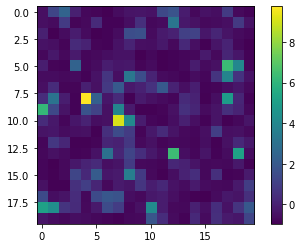

In [4]:
# Plot one representative field

plt.imshow(lognormfields[0]['field'])
plt.colorbar()

In [5]:
# Limit the number of bins so the maximum separation does not exceed rmax
ndata = min(ndata, LN.nonzerobins)

# Compute the mean correlation function from the list of LN field objects, and its covariance
mean2pt, cov = LN.covariance(lognormfields)

# Compute the theory
xiLN = LN.xi_LN(LN.average_r,beta,alpha,PixelNoise)

# Compute gradients
dxiLN_dalpha = LN.dxi_LN_dalpha(LN.average_r,beta,alpha,PixelNoise)
dxiLN_dbeta = LN.dxi_LN_dbeta(LN.average_r,beta,alpha,PixelNoise)

Number of simulations 500
Number of non-zero pair bins 68


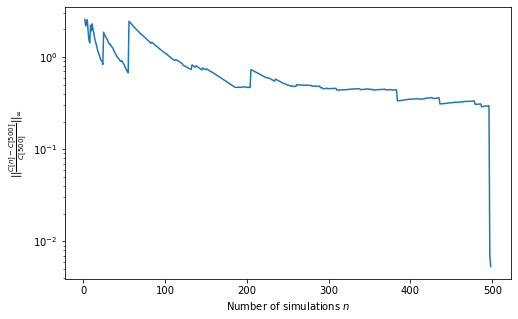

In [6]:
# Plot convergence of the covariance matrix

sims = np.array([lognormfields[n]['corrfn'] for n in range(nsims)])
cov_rel_error_inf = np.array([np.linalg.norm(cov-np.cov(sims[:n].T),ord=np.inf)/np.linalg.norm(cov,ord=np.inf) for n in range(2,nsims-1)])
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Number of simulations $n$")
ax.set_ylabel("$||\\frac{C[n]-C["+str(nsims)+"]}{C["+str(nsims)+"]}||_{\infty}$")
ax.semilogy(np.arange(2,nsims-1),cov_rel_error_inf)

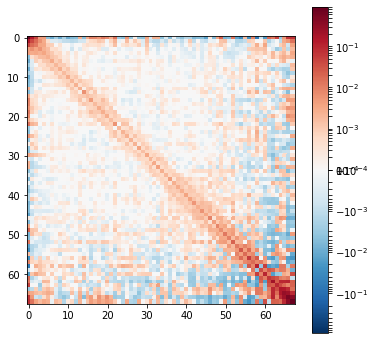

In [7]:
# Plot the covariance matrix

import matplotlib.colors as colors
plt.figure(figsize=(6,6))
plt.pcolormesh(np.arange(ndata), np.arange(ndata), cov,
                       norm=colors.SymLogNorm(linthresh=0.0001, linscale=0.001,
                                              vmin=-cov.max(), vmax=cov.max(), base=10),
                       cmap='RdBu_r', shading='auto')

plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
plt.colorbar()
plt.show()

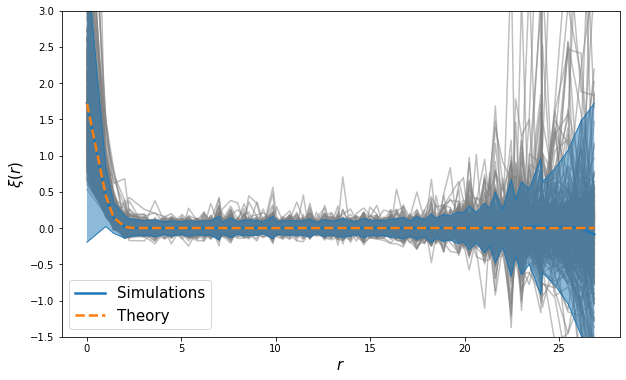

In [8]:
# Plot the correlation function

plt.figure(figsize=(10,6))
plt.xlabel('$r$',fontsize=15)
plt.ylabel('$\\xi(r)$',fontsize=15)
plt.ylim([-1.5,3])
for i in range(nsims):
    plt.plot(LN.average_r,lognormfields[i]['corrfn'],color="grey",alpha=0.5,zorder=0.5)

# Plot the mean correlation function:
plt.plot(LN.average_r,mean2pt,lw=2.5,label="Simulations")

# Plot the diagonal of the covariance matrix.  Wild fluctuations are from varying numbers of pairs per bin
plt.fill_between(LN.average_r,mean2pt-2*np.sqrt(np.diag(cov)),mean2pt+2*np.sqrt(np.diag(cov)),alpha=0.5)
plt.plot(LN.average_r,mean2pt-2*np.sqrt(np.diag(cov)),c='C0',lw=1.)
plt.plot(LN.average_r,mean2pt+2*np.sqrt(np.diag(cov)),c='C0',lw=1.)

# Plot the mean correlation function and the theory with the correct alpha, beta :
plt.plot(LN.average_r,xiLN,ls='--',lw=2.5,label="Theory")

plt.legend(fontsize=15)

In [9]:
np.savez(dataout+'_mean_cov_theory',average_r=LN.average_r,mean2pt=mean2pt,cov=cov,xiLN=xiLN,dxiLN_dalpha=dxiLN_dalpha,dxiLN_dbeta=dxiLN_dbeta)

# Inference with summary statistics

In [10]:
print('Condition number of covariance matrix =',np.linalg.cond(cov))

invcov   = np.linalg.inv(cov)
ave_r    = LN.average_r

print('ndata',ndata)
print('Max radius/pixel size',ave_r.max())

Condition number of covariance matrix = 3766.552804153464
ndata 68
Max radius/pixel size 26.870057685088806


In [11]:
# Summary statistics: infer alpha and beta.  Use Sellentin-Heavens likelihood.

def lnL_LN(LN,alpha,beta,xi,invcov,nsims,PixelNoise):
    """
    Compute the ln likelihood
    
    Parameters:
        LN : LogNormalField instance
            log-normal field setup
        alpha : float
            nongaussianity parameter in lognormal model
        beta  : float
            width of gaussian correlation function
        xi : float array
            two-point correlation function (the data)
        invcov : float matrix
            Inverse covariance matrix of the data (ndata x ndata)
        nsims : int
            Number of simulations used to estimate the covariance matrix
        PixelNoise : float
            Standard deviation of added noise per pixel
    """
    
    ave_r   = LN.average_r
    ndata   = LN.nonzerobins
    ndatax  = xi.size
    ndatac1 = invcov.shape[0]
    ndatac2 = invcov.shape[1]
    
    assert ndata == ndatax
    assert ndata == ndatac1
    assert ndata == ndatac2
    
    if(alpha<0):
        return -np.inf
    
    data = xi
    invC = invcov
    
    theory = LN.xi_LN(ave_r,beta,alpha,PixelNoise)
    
    lnLike_SH   = Sellentin_Heavens(data,theory,invC,nsims)
    
    return lnLike_SH

def Sellentin_Heavens(data,theory,invC,nsims):
    """
    Compute the Sellentin-Heavens likelihood (Sellentin & Heavens 2016)
    
    Parameters:
        data : float (array of size N)
            data vector (xi, in this case)
        theory : float (array of size N)
            theory vector
        invC : float (N x N)
            inverse covariance matrix
        nsims : int
            Number of simulations used to estimate the covariance matrix        
    """
        
    diff   = data-theory
    chisq  = np.dot(diff,np.dot(invC,diff))
    
    lnL_SH =  -0.5*nsims*np.log(1+chisq/(nsims-1)) 
    
    return lnL_SH

In [12]:
# Compute lnL on a grid
nfields = 4
alphas  = np.linspace(alphamin+1e-3,alphamax,nalpha)
betas   = np.linspace(betamin,betamax,nbeta)
lnL     = np.zeros((nfields,nalpha,nbeta))

for f in range(nfields):
    data = lognormfields[f]['corrfn']
    lnL[f,:,:] = [[lnL_LN(LN,alphas[ialpha],betas[ibeta],data,invcov,nsims,PixelNoise) for ialpha in range(nalpha)] for ibeta in range(nbeta)]
    lnL[f,:,:] -= np.max(lnL[f,:,:])

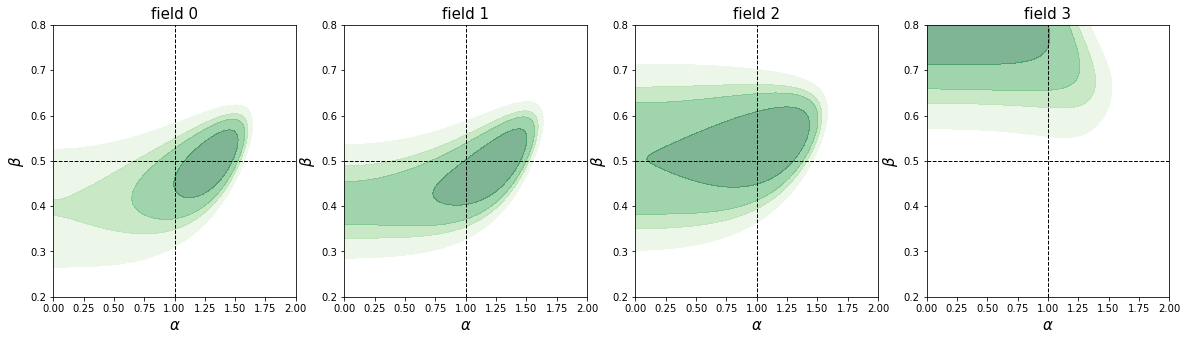

In [13]:
fig=plt.figure(figsize=(20,5))
ax0=fig.add_subplot(1,4,1)
ax0.set_xlabel("$\\alpha$",fontsize=15)
ax0.set_ylabel("$\\beta$",fontsize=15)
ax0.set_title("field 0",fontsize=15)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
ax0.axvline(alpha,lw=1,ls="--",color="k")
ax0.axhline(beta,lw=1,ls="--",color="k")
ax0.contourf(alphas,betas,lnL[0,:,:],contour_levels,cmap="Greens",alpha=0.5)
ax1=fig.add_subplot(1,4,2)
ax1.set_xlabel("$\\alpha$",fontsize=15)
ax1.set_ylabel("$\\beta$",fontsize=15)
ax1.set_title("field 1",fontsize=15)
ax1.set_xlim([alphamin,alphamax])
ax1.set_ylim([betamin,betamax])
ax1.axvline(alpha,lw=1,ls="--",color="k")
ax1.axhline(beta,lw=1,ls="--",color="k")
ax1.contourf(alphas,betas,lnL[1,:,:],contour_levels,cmap="Greens",alpha=0.5)
ax2=fig.add_subplot(1,4,3)
ax2.set_xlabel("$\\alpha$",fontsize=15)
ax2.set_ylabel("$\\beta$",fontsize=15)
ax2.set_title("field 2",fontsize=15)
ax2.set_xlim([alphamin,alphamax])
ax2.set_ylim([betamin,betamax])
ax2.axvline(alpha,lw=1,ls="--",color="k")
ax2.axhline(beta,lw=1,ls="--",color="k")
ax2.contourf(alphas,betas,lnL[2,:,:],contour_levels,cmap="Greens",alpha=0.5)
ax3=fig.add_subplot(1,4,4)
ax3.set_xlabel("$\\alpha$",fontsize=15)
ax3.set_ylabel("$\\beta$",fontsize=15)
ax3.set_title("field 3",fontsize=15)
ax3.set_xlim([alphamin,alphamax])
ax3.set_ylim([betamin,betamax])
ax3.axvline(alpha,lw=1,ls="--",color="k")
ax3.axhline(beta,lw=1,ls="--",color="k")
ax3.contourf(alphas,betas,lnL[3,:,:],contour_levels,cmap="Greens",alpha=0.5)

# Combination of several independent fields

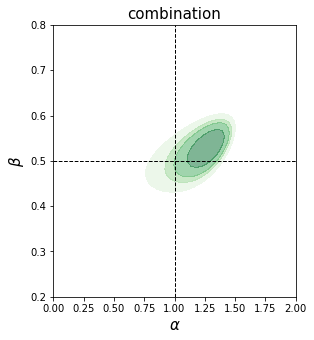

In [14]:
sumlnL = np.sum([lnL[f,:,:] for f in range(nfields)],axis=0)
sumlnL -= np.max(sumlnL)
epsilon=0.05

fig=plt.figure(figsize=(20,5))
ax0=fig.add_subplot(1,4,1)
ax0.set_xlabel("$\\alpha$",fontsize=15)
ax0.set_ylabel("$\\beta$",fontsize=15)
ax0.set_title("combination",fontsize=15)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
ax0.axvline(alpha,lw=1,ls="--",color="k")
ax0.axhline(beta,lw=1,ls="--",color="k")
ax0.contourf(alphas,betas,sumlnL,contour_levels,cmap="Greens",alpha=0.5)

In [15]:
np.savez(dataout+'_summaries_'+str(nfields)+'fields',alphas=alphas,betas=betas,
         lnL0=lnL[0,:,:],
         lnL1=lnL[1,:,:],
         lnL2=lnL[2,:,:],
         lnL3=lnL[3,:,:],
         lnL=sumlnL)